# Sentiment in tweet using supervised and unsupervised techniques

Can you imagine going through a pandemic without the Internet? Humanity quickly adjusted how to do business online from remote work, shopping, online learning, exchanging ideas and opinions and everything in between. The Internet has become a platform for all necessity to move society forward. Social networking sites like Twitter, Facebook, Google+ are extremely important to share and express views about anything across the entire world with different communities. We all know people are highly sensitive and reactive to topics like: politics, religions, entertainment, sport, products and so on. There has been a lot of important work in the field of sentiment analysis. This helps us to analyze information in the social network, where opinions are highly unstructured, heterogeneous and are either positive, negative or neutral.

In this notebook we explore how to prepare the tweet dataset, create new features and transform the text data to numerical data, Finally we build a traditional classification model opposed to a more advansed deep learning algorithm. We are also going to implement an unsupervised sentiment analysis model to showcase how sentiment can be obtained without the need for labeled data.

The dataset is from kaggle and can be found: [here](https://www.kaggle.com/jp797498e/twitter-entity-sentiment-analysis/tasks).

In [1]:
import sys  
sys.path.append('../src/visualization')
sys.path.append('../src/processing')

In [10]:
sys.path

['/home/charlie/Documents/DATA_SCIENCE_HOME/NLP_HOME/sentimentanalysis/notebooks',
 '/home/charlie/anaconda3/envs/fraud/lib/python38.zip',
 '/home/charlie/anaconda3/envs/fraud/lib/python3.8',
 '/home/charlie/anaconda3/envs/fraud/lib/python3.8/lib-dynload',
 '',
 '/home/charlie/.local/lib/python3.8/site-packages',
 '/home/charlie/anaconda3/envs/fraud/lib/python3.8/site-packages',
 '../src/visualization',
 '../src/processing']

In [2]:
%matplotlib inline

#Data management
import re
import pandas as pd
import numpy as np
from collections import Counter
from wordcloud import WordCloud

from TextFeatureEngineering import *
from DataCleansing import *

#TextBlob Features
from textblob import TextBlob

#Plotting
import matplotlib.pyplot as plt
import seaborn as sns

#SciKit-Learn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

#nltk
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
# nltk.download('wordnet')
# nltk.download('stopwords')
# nltk.download('punkt')
# nltk.download('words')

#Tensorflow / Keras
import tensorflow as tf
from keras.models import load_model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

np.random.seed(0)

import warnings
warnings.simplefilter("ignore")

Importing the Dependencies and Loading the Data

In [15]:
# Loading training dataset
path = '../data/external/twitter_training.csv'
train_df = pd.read_csv(path, names=["Tweet_ID", "Entity", "Sentiment", "Tweet_Content"])

# Loading testing dataset
test_path = '../data/external/twitter_validation.csv'
test_df = pd.read_csv(test_path, names=["Tweet_ID", "Entity", "Sentiment", "Tweet_Content"])

The data dimensions from the training dataset. We have 74682 tweets for training with 4 attributes.

In [71]:
n_reviews, n_attributes = train_df.shape
print('Total tweets in training dataset: ',n_reviews)
print('Total attributes in training dataset: ',n_attributes)

Total tweets in training dataset:  74682
Total attributes in training dataset:  4


The data dimensions from the testing dataset. We have 1000 tweets for testing with 
4 attributes.

In [72]:
n_reviews, n_attributes = test_df.shape
print('Total tweet in testing dataset: ',n_reviews)
print('Total attributes in testing dataset: ',n_attributes)

Total tweet in testing dataset:  1000
Total attributes in testing dataset:  4


# Exploratory Data Analysis

## Handling Missing Data

Missing data can skew anything for data scientists. After all, any analysis is only as good as the data. A data scientist doesn’t want to produce biased estimates that lead to invalid results. When dealing with missing data, data scientists must understand why the data is missing. Some consideration:

* Data missing at Random?
* Missing Completely at Random?
* Missing Not at Random?

There are many approaches for dealing with missing data:

* Deleting data
*  Imputation

When data is missing, it may make sense to delete data, as mentioned above. However, that may not be the most effective option. For example, if too much information is discarded, it may not be possible to complete a reliable analysis.

Instead of deletion, data scientists have multiple solutions to impute the value of missing data. Depending why the data are missing, imputation methods can deliver reasonably reliable results.

For simplicity, we opted to reduce all the features that contain missing values.

The code below shows all the features with missing values in percentage.

In [73]:
missing_values = train_df.isna().mean().round(4) * 100
print('%s%%' % missing_values)

Tweet_ID         0.00
Entity           0.00
Sentiment        0.00
Tweet_Content    0.92
dtype: float64%


In [74]:
missing_values = test_df.isna().mean().round(4) * 100
print('%s%%' % missing_values)

Tweet_ID         0.0
Entity           0.0
Sentiment        0.0
Tweet_Content    0.0
dtype: float64%


In [75]:
train_df.head()

,Tweet_ID,Entity,Sentiment,Tweet_Content
0,2401,Borderlands,Positive,im getting on borderlands and i will murder yo...
1,2401,Borderlands,Positive,I am coming to the borders and I will kill you...
2,2401,Borderlands,Positive,im getting on borderlands and i will kill you ...
3,2401,Borderlands,Positive,im coming on borderlands and i will murder you...
4,2401,Borderlands,Positive,im getting on borderlands 2 and i will murder ...


The 'Tweet_Content' feature has 0.92% missing values. We will attempt to reduce the tweets with missing values

In [76]:
train_df = train_df.dropna()

In [77]:
missing_values = train_df.isna().mean().round(4) * 100
print('%s%%' % missing_values)

Tweet_ID         0.0
Entity           0.0
Sentiment        0.0
Tweet_Content    0.0
dtype: float64%


The code below maps the boolean values to numerical values used as the target variable. We can also notice that there are slightly higher negative tweets than other sentiments, we also have a multi-class problem. Overall, all classes are pretty balanced.

<BarContainer object of 4 artists>

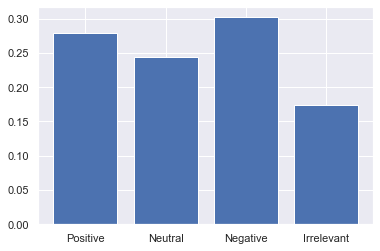

In [78]:
#Checking balance of target classes
sentiments = list(train_df["Sentiment"].unique())

sentiment_nums = [len(train_df[train_df["Sentiment"] == sentiment]) / len(train_df) for sentiment in sentiments]

plt.bar(sentiments, sentiment_nums)

In [3]:
#Define the indexing for each possible label in a dictionary
class_to_index = {"Neutral":0, "Irrelevant":1, "Negative":2, "Positive": 3}

#Creates a reverse dictionary
index_to_class = dict((v,k) for k, v in class_to_index.items())

#Creates lambda functions, applying the appropriate dictionary
names_to_ids = lambda n: np.array([class_to_index.get(x) for x in n])
ids_to_names = lambda n: np.array([index_to_class.get(x) for x in n])

In [4]:
#Test each function
print(names_to_ids(["Positive", "Negative", "Irrelevant", "Neutral"]))
print(ids_to_names([0,1,2,3]))

[3 2 1 0]
['Neutral' 'Irrelevant' 'Negative' 'Positive']


In [81]:
#Convert the "Sentiment" column into indexes
train_df["Sentiment"] = names_to_ids(train_df["Sentiment"])
test_df["Sentiment"] = names_to_ids(test_df["Sentiment"])

In [82]:
train_df.head()

,Tweet_ID,Entity,Sentiment,Tweet_Content
0,2401,Borderlands,3,im getting on borderlands and i will murder yo...
1,2401,Borderlands,3,I am coming to the borders and I will kill you...
2,2401,Borderlands,3,im getting on borderlands and i will kill you ...
3,2401,Borderlands,3,im coming on borderlands and i will murder you...
4,2401,Borderlands,3,im getting on borderlands 2 and i will murder ...


In [83]:
test_df.head()

,Tweet_ID,Entity,Sentiment,Tweet_Content
0,3364,Facebook,1,I mentioned on Facebook that I was struggling ...
1,352,Amazon,0,BBC News - Amazon boss Jeff Bezos rejects clai...
2,8312,Microsoft,2,@Microsoft Why do I pay for WORD when it funct...
3,4371,CS-GO,2,"CSGO matchmaking is so full of closet hacking,..."
4,4433,Google,0,Now the President is slapping Americans in the...


In [84]:
np.unique(train_df['Entity'])

array(['Amazon', 'ApexLegends', 'AssassinsCreed', 'Battlefield',
       'Borderlands', 'CS-GO', 'CallOfDuty', 'CallOfDutyBlackopsColdWar',
       'Cyberpunk2077', 'Dota2', 'FIFA', 'Facebook', 'Fortnite', 'Google',
       'GrandTheftAuto(GTA)', 'Hearthstone', 'HomeDepot',
       'LeagueOfLegends', 'MaddenNFL', 'Microsoft', 'NBA2K', 'Nvidia',
       'Overwatch', 'PlayStation5(PS5)',
       'PlayerUnknownsBattlegrounds(PUBG)', 'RedDeadRedemption(RDR)',
       'TomClancysGhostRecon', 'TomClancysRainbowSix', 'Verizon',
       'WorldOfCraft', 'Xbox(Xseries)', 'johnson&johnson'], dtype=object)

From the Figure below we can see what category have more negative and positive tweets. We see that these categories have very negative tweets: NBA2k, Verizon, FIFA, TomClancysRainbowSix, CallOfDuty, MaddenNFL, and so on. 
On the contrary, AssassinsCreed, Borderlands, CallOfDutyBlackopsColdWar, Xbox(Xseries), PlayStation5(PS5) and so on, have positive tweets.

Text(0.5, 1.0, 'Count of tweet category')

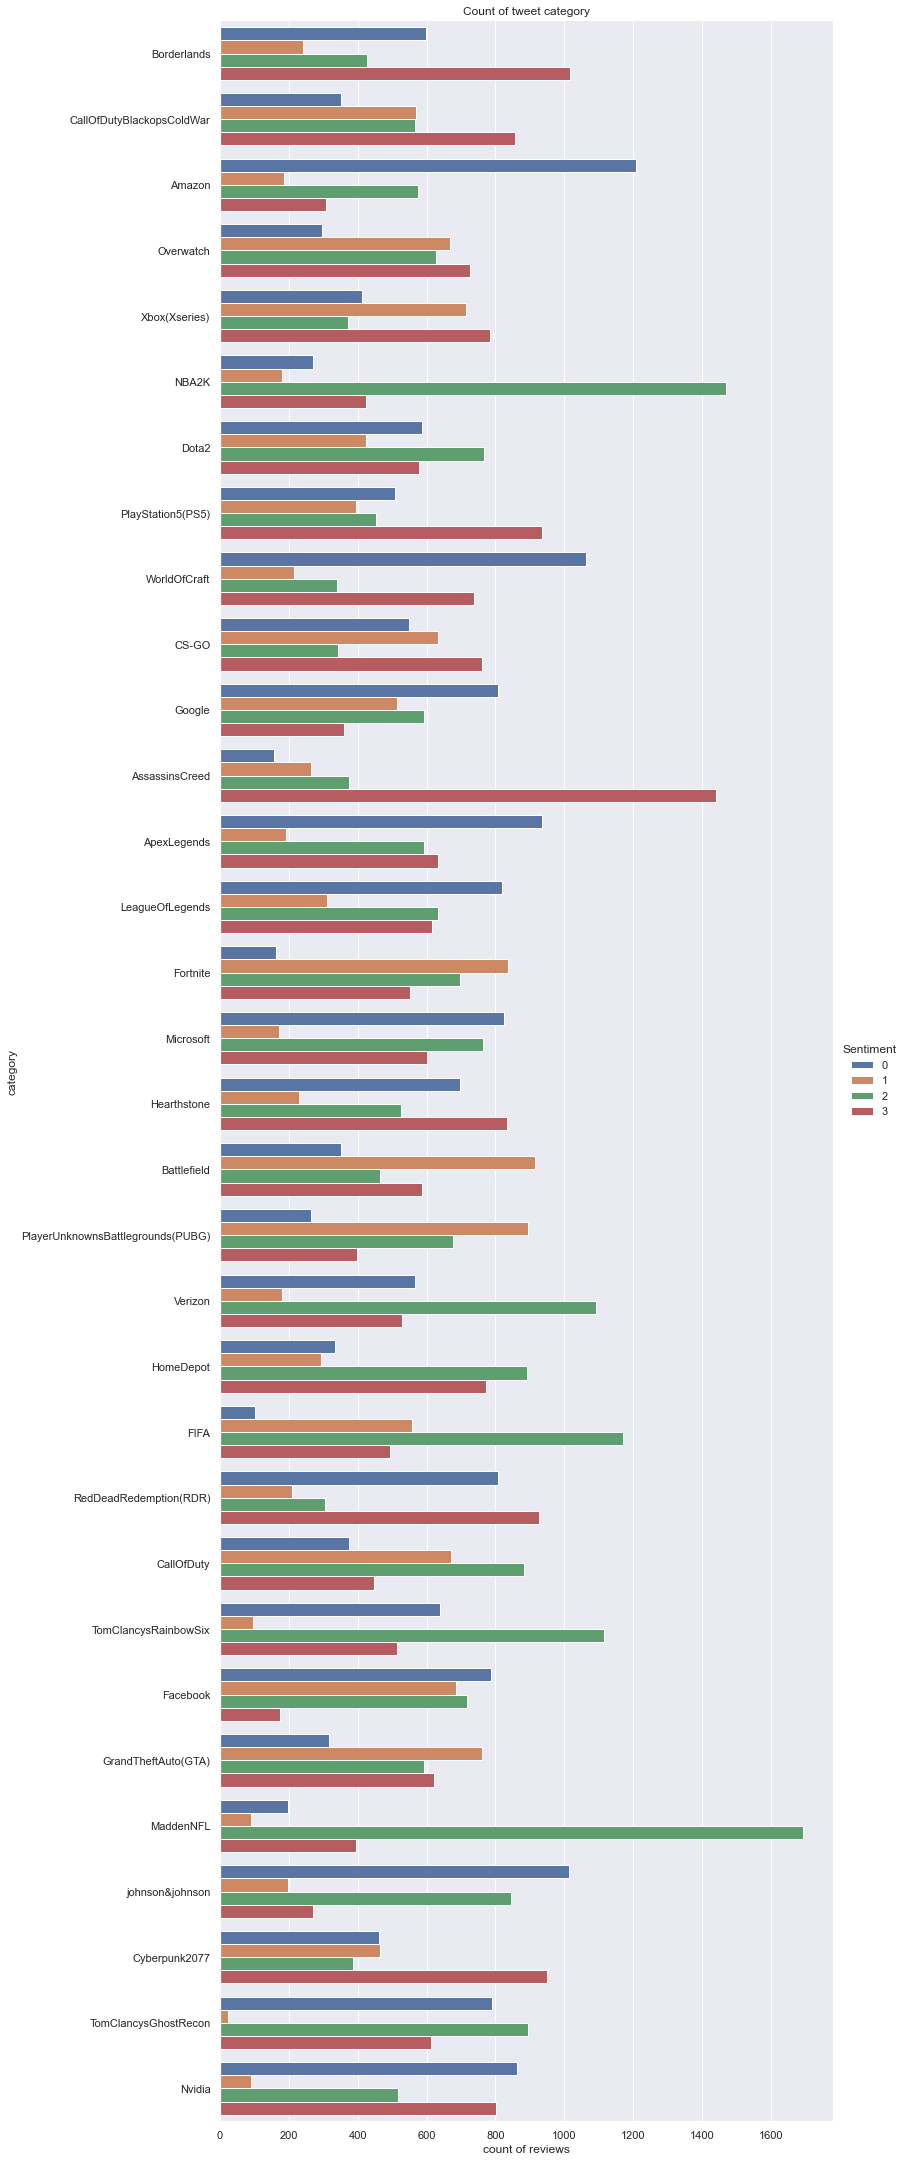

In [44]:
sns.catplot(y ='Entity',kind='count', hue = 'Sentiment', data=train_df,  height=30, aspect=0.4)
plt.ylabel("category")
plt.xlabel("count of reviews")
plt.title("Count of tweet category")

Check total duplicate occurrences and remove them.

In [85]:
dup = train_df.duplicated().sum()
print('Number of duplicates in dataset: ', dup)

Number of duplicates in dataset:  2340


In [86]:
train_df = train_df.drop_duplicates().reset_index(drop=True)
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 71656 entries, 0 to 71655
Data columns (total 4 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Tweet_ID       71656 non-null  int64 
 1   Entity         71656 non-null  object
 2   Sentiment      71656 non-null  int64 
 3   Tweet_Content  71656 non-null  object
dtypes: int64(2), object(2)
memory usage: 2.2+ MB


In [87]:
dup = train_df.duplicated().sum()
print('Number of duplicates in dataset: ', dup)

Number of duplicates in dataset:  0


In [88]:
dup = test_df.duplicated().sum()
print('Number of duplicates in dataset: ', dup)

Number of duplicates in dataset:  0


## Converting Nominal Variables

Most machine learning algorithms can't handle categorical data. We use label encoders to handle nominal variables! 

In [89]:
# Encode Categorical Columns
le = LabelEncoder()

train_df.Entity = le.fit_transform(train_df.Entity)
test_df.Entity = le.transform(test_df.Entity)

In [90]:
train_df.Entity.head()

0    4
1    4
2    4
3    4
4    4
Name: Entity, dtype: int64

# Utilizing Natural Language Processing

Before we clean the text features we will attempt to extract some insight from the text. Below is a set of functions that look at the counts of various aspects, such as: word, sentens, character counts.

In [91]:
def make_feature(df, feature_name_in):
    tmp_df = df.copy()
    tmp_df['char_count'] = tmp_df[feature_name_in].apply(lambda x:count_chars(x))
    tmp_df['word_count'] = tmp_df[feature_name_in].apply(lambda x:count_words(x))
    tmp_df['sent_count'] = tmp_df[feature_name_in].apply(lambda x:count_sent(x))
    tmp_df['capital_char_count'] = tmp_df[feature_name_in].apply(lambda x:count_capital_chars(x))
    tmp_df['capital_word_count'] = tmp_df[feature_name_in].apply(lambda x:count_capital_words(x))
    tmp_df['quoted_word_count'] = tmp_df[feature_name_in].apply(lambda x:count_words_in_quotes(x))
    tmp_df['stopword_count'] = tmp_df[feature_name_in].apply(lambda x:count_stopwords(x))
    tmp_df['unique_word_count'] = tmp_df[feature_name_in].apply(lambda x:count_unique_words(x))
    tmp_df['htag_count'] = tmp_df[feature_name_in].apply(lambda x:count_htags(x))
    tmp_df['mention_count'] = tmp_df[feature_name_in].apply(lambda x:count_mentions(x))
    tmp_df['punct_count'] = tmp_df[feature_name_in].apply(lambda x:count_punctuations(x))
    tmp_df['avg_wordlength']= tmp_df['char_count']/tmp_df['word_count']
    tmp_df['avg_sentlength']= tmp_df['word_count']/tmp_df['sent_count']
    tmp_df['unique_vs_words']= tmp_df['unique_word_count']/tmp_df['word_count']
    tmp_df['stopwords_vs_words']= tmp_df['stopword_count']/tmp_df['word_count']
    
    return tmp_df

In [92]:
train_df = make_feature(train_df, 'Tweet_Content')
test_df = make_feature(test_df, 'Tweet_Content')

The 'punct_count' feature is represented as a dictionary. The below code attempts to expand to columns.

In [93]:
def expand_punct_column(_df):
    df_punct= pd.DataFrame(list(_df.punct_count))
    
    # Merging the pnctuation DataFrame with main DataFrame
    _df=pd.merge(_df, df_punct, left_index=True, right_index=True)
    
    # We can drop "punct_count" column.
    _df.drop(columns=['punct_count'], inplace=True)
    
    return _df

In [94]:
train_df = expand_punct_column(train_df)
test_df = expand_punct_column(test_df)

In [95]:
train_df.head()

,Tweet_ID,Entity,Sentiment,Tweet_Content,char_count,word_count,sent_count,capital_char_count,capital_word_count,quoted_word_count,...,[ count,\ count,] count,^ count,_ count,` count,{ count,| count,} count,~ count
0,2401,4,3,im getting on borderlands and i will murder yo...,53,11,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2401,4,3,I am coming to the borders and I will kill you...,51,12,1,2,2,0,...,0,0,0,0,0,0,0,0,0,0
2,2401,4,3,im getting on borderlands and i will kill you ...,50,10,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,2401,4,3,im coming on borderlands and i will murder you...,51,10,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,2401,4,3,im getting on borderlands 2 and i will murder ...,57,12,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [96]:
test_df.head()

,Tweet_ID,Entity,Sentiment,Tweet_Content,char_count,word_count,sent_count,capital_char_count,capital_word_count,quoted_word_count,...,[ count,\ count,] count,^ count,_ count,` count,{ count,| count,} count,~ count
0,3364,11,1,I mentioned on Facebook that I was struggling ...,242,47,1,6,2,0,...,0,0,0,0,0,0,0,0,0,0
1,352,0,0,BBC News - Amazon boss Jeff Bezos rejects clai...,109,16,1,7,1,0,...,0,0,0,0,0,0,0,0,0,0
2,8312,19,2,@Microsoft Why do I pay for WORD when it funct...,91,17,2,11,2,0,...,0,0,0,0,0,0,0,0,0,0
3,4371,5,2,"CSGO matchmaking is so full of closet hacking,...",71,13,1,4,1,0,...,0,0,0,0,0,0,0,0,0,0
4,4433,13,0,Now the President is slapping Americans in the...,170,25,2,6,0,0,...,0,0,0,0,0,0,0,0,0,0


IDs don't directly add value for the tweet model, so we will drop the ID features below!

In [97]:
train_df.drop(['Tweet_ID'], inplace=True, axis=1)
test_df.drop(['Tweet_ID'], inplace=True, axis=1)

In [98]:
train_df.head()

,Entity,Sentiment,Tweet_Content,char_count,word_count,sent_count,capital_char_count,capital_word_count,quoted_word_count,stopword_count,...,[ count,\ count,] count,^ count,_ count,` count,{ count,| count,} count,~ count
0,4,3,im getting on borderlands and i will murder yo...,53,11,1,0,0,0,6,...,0,0,0,0,0,0,0,0,0,0
1,4,3,I am coming to the borders and I will kill you...,51,12,1,2,2,0,7,...,0,0,0,0,0,0,0,0,0,0
2,4,3,im getting on borderlands and i will kill you ...,50,10,1,0,0,0,6,...,0,0,0,0,0,0,0,0,0,0
3,4,3,im coming on borderlands and i will murder you...,51,10,1,0,0,0,6,...,0,0,0,0,0,0,0,0,0,0
4,4,3,im getting on borderlands 2 and i will murder ...,57,12,1,0,0,0,7,...,0,0,0,0,0,0,0,0,0,0


In [99]:
test_df.head()

,Entity,Sentiment,Tweet_Content,char_count,word_count,sent_count,capital_char_count,capital_word_count,quoted_word_count,stopword_count,...,[ count,\ count,] count,^ count,_ count,` count,{ count,| count,} count,~ count
0,11,1,I mentioned on Facebook that I was struggling ...,242,47,1,6,2,0,26,...,0,0,0,0,0,0,0,0,0,0
1,0,0,BBC News - Amazon boss Jeff Bezos rejects clai...,109,16,1,7,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,19,2,@Microsoft Why do I pay for WORD when it funct...,91,17,2,11,2,0,7,...,0,0,0,0,0,0,0,0,0,0
3,5,2,"CSGO matchmaking is so full of closet hacking,...",71,13,1,4,1,0,5,...,0,0,0,0,0,0,0,0,0,0
4,13,0,Now the President is slapping Americans in the...,170,25,2,6,0,0,11,...,0,0,0,0,0,0,0,0,0,0


Next we apply a fleet of functions to clean text features and remove common and rare words. We remove:

* Repeated characters
* Separate digit
* Slang
* Stem words
* Single characters
* Punctuations
* Extra space
* Replace digits with characters
* Emoticons
* URL
* Alphanumerics
* Stop words

In [100]:
def clean_feature(_df, feature_name):
    _df[feature_name] = _df[feature_name].apply(lambda i: appos_look_up(i))
    _df[feature_name] = _df[feature_name].apply(lambda i: remove_repeated_characters(i))
    _df[feature_name] = _df[feature_name].apply(lambda i: separate_digit_text(i))
    _df[feature_name] = _df[feature_name].apply(lambda i: slang_look_up(i))
    _df[feature_name] = _df[feature_name].apply(lambda i: stem_text(i))
    _df[feature_name] = _df[feature_name].apply(lambda i: remove_single_char_word(i))
    _df[feature_name] = _df[feature_name].apply(lambda i: remove_punctuations(i))
    _df[feature_name] = _df[feature_name].apply(lambda i: remove_extra_space(i))
    _df[feature_name] = _df[feature_name].apply(lambda i: replace_digits_with_char(i))
    _df[feature_name] = _df[feature_name].apply(lambda i: emoticons_look_up(i)[0])
    _df[feature_name] = _df[feature_name].apply(lambda i: remove_url(i))
    _df[feature_name] = _df[feature_name].apply(lambda i: remove_alphanumerics(i))
    _df[feature_name] = _df[feature_name].apply(lambda i: remove_stop_words(i))
    
    _df[feature_name] = _df[feature_name].apply(lambda i: ''.join(TextBlob(i).correct()))
    
    # removing common and rare words
    common = pd.Series(' '.join(_df[feature_name]).split()).value_counts()[:3]
    common = list(common.index)
    _df[feature_name] = _df[feature_name].apply(lambda i: " ".join(i for i in i.split() if i not in common))
    
    rare = pd.Series(' '.join(_df[feature_name]).split()).value_counts()[-3:]
    rare = list(rare.index)
    _df[feature_name] = _df[feature_name].apply(lambda i: " ".join(i for i in i.split() if i not in rare))
    
    
    return _df

Cleaning the text features will take a very, very long time. You can take one or two or more coffee cups!!!

In [101]:
train_df = clean_feature(train_df, 'Tweet_Content')
test_df = clean_feature(test_df, 'Tweet_Content')

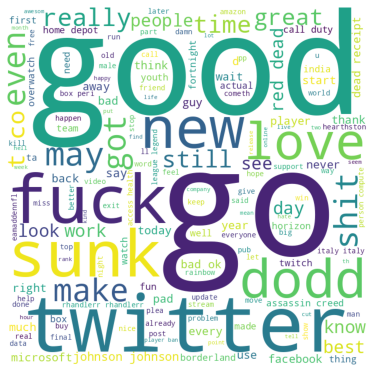

In [103]:
#WordCloud

words = '' 
for i in train_df["Tweet_Content"]: 
    tokens = i.split()   
    words += " ".join(tokens)+" "

    
word_cloud = WordCloud(width=700, height=700, background_color='white', min_font_size=10).generate(words) 
plt.figure(figsize = (5, 5)) 
plt.imshow(word_cloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

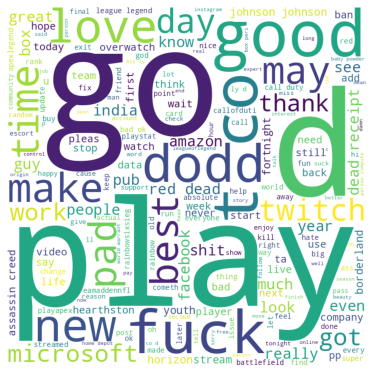

In [104]:
#WordCloud

words = '' 
for i in test_df["Tweet_Content"]: 
    tokens = i.split()   
    words += " ".join(tokens)+" "

    
word_cloud = WordCloud(width=700, height=700, background_color='white', min_font_size=10).generate(words) 
plt.figure(figsize = (5, 5)) 
plt.imshow(word_cloud) 
plt.axis("off") 
plt.tight_layout(pad = 0) 
  
plt.show()

### Saving cleaned dataframe.

In [105]:
train_df.to_csv('../data/processed/cleaned_tweet_train.csv')
test_df.to_csv('../data/processed/cleaned_tweet_test.csv')

# Training ML models

Text features are considered unstructured data. Tokenization of text document can be indirectly used for representing documents. We often need to use algorithms like, term frequency–inverse document frequency (TF-IDF) to account for token occurrences (meaning we break the sentence into words or tokens) in a document and turn an unstructured text into a numerical vector that is suitable for machine learning. There are many other techniques that can be used to convert text to numerical sequences. We will use tensorflow’s library to perform both the Tokenization and to convert to numerical vectors, known as embeddings.

# Run below code to get data from local file system. 

In [222]:
# Due to special charas should be encoded as latin 1

train_df = pd.read_csv("../data/processed/cleaned_tweet_train.csv")
train_df.drop(['Unnamed: 0'], axis=1, inplace=True)

test_df = pd.read_csv("../data/processed/cleaned_tweet_test.csv")
test_df.drop(['Unnamed: 0'], axis=1, inplace=True)

# Or, run below cell's to get data from Snowflake

You can establish a connection and get a Pandas DataFrame. Just fill '<...>' with your Snowflake account credentials!!!

In [5]:
import snowflake.connector as sc
import snowflake.connector.pandas_tools as pt
from snowflake.connector.pandas_tools import write_pandas

In [7]:
database = '<database name>'
schema='<schema name>'
table_name_train='SENTIMENT_ANALYSIS_TRAIN'
table_name_test='SENTIMENT_ANALYSIS_TEST'

In [8]:
ctx = sc.connect(
    user='<user name>',
    password='<password to the database>',
    account='<account>',
    warehouse='<warehouse name>',
    database=database,
    schema=schema,
    protocol='https',
    port=443
)

In [9]:
cur = ctx.cursor()

In [10]:
query = cur.execute(f"SELECT * FROM <database name>.<schema name>.SENTIMENT_ANALYSIS_TRAIN")

In [11]:
train_df = query.fetch_pandas_all()

In [12]:
query = cur.execute(f"SELECT * FROM <database name>.<schema name>.SENTIMENT_ANALYSIS_TEST")

In [13]:
test_df = query.fetch_pandas_all()

In [14]:
train_df.shape

(71656, 49)

In [15]:
train_df.head()

,ENT1,SENTIMENT,TWEET_CONTENT,CHAR_COUNT,WORD_COUNT,SENT_COUNT,CAPITAL_CHAR_COUNT,CAPITAL_WORD_COUNT,QUOTED_WORD_COUNT,STOPWORD_COUNT,...,CHARACTER_40,CHARACTER_41,CHARACTER_42,CHARACTER_43,CHARACTER_44,CHARACTER_45,CHARACTER_46,CHARACTER_47,CHARACTER_48,CHARACTER_49
0,4,3,get borderland murder,53,11,1,0,0,0,6,...,0,0,0,0,0,0,0,0,0,0
1,4,3,border kill,51,12,1,2,2,0,7,...,0,0,0,0,0,0,0,0,0,0
2,4,3,get borderland kill,50,10,1,0,0,0,6,...,0,0,0,0,0,0,0,0,0,0
3,4,3,borderland murder,51,10,1,0,0,0,6,...,0,0,0,0,0,0,0,0,0,0
4,4,3,get borderland murder,57,12,1,0,0,0,7,...,0,0,0,0,0,0,0,0,0,0


In [16]:
test_df.head()

,ENTITY,SENTIMENT,TWEET_CONTENT,CHAR_COUNT,WORD_COUNT,SENT_COUNT,CAPITAL_CHAR_COUNT,CAPITAL_WORD_COUNT,QUOTED_WORD_COUNT,STOPWORD_COUNT,...,CHARACTER_40,CHARACTER_41,CHARACTER_42,CHARACTER_43,CHARACTER_44,CHARACTER_45,CHARACTER_46,CHARACTER_47,CHARACTER_48,CHARACTER_49
0,11,1,mention facebook struggle motive go run day tr...,242,47,1,6,2,0,26,...,0,0,0,0,0,0,0,0,0,0
1,0,0,bc news amazon boss jeff be reject claim compa...,109,16,1,7,1,0,1,...,0,0,0,0,0,0,0,0,0,0
2,19,2,microsoft pay word function poor samsungus chr...,91,17,2,11,2,0,7,...,0,0,0,0,0,0,0,0,0,0
3,5,2,so watchman full closet hack truly a,71,13,1,4,1,0,5,...,0,0,0,0,0,0,0,0,0,0
4,13,0,preside slap american really commit law act ac...,170,25,2,6,0,0,11,...,0,0,0,0,0,0,0,0,0,0


In [17]:
n_reviews, n_attributes = train_df.shape
print('Total tweets in training dataset: ',n_reviews)
print('Total attributes in training dataset: ',n_attributes)

print('\n==============\n')

n_reviews, n_attributes = test_df.shape
print('Total tweet in testing dataset: ',n_reviews)
print('Total attributes in testing dataset: ',n_attributes)

Total tweets in training dataset:  71656
Total attributes in training dataset:  49


Total tweet in testing dataset:  1000
Total attributes in testing dataset:  49


In [18]:
train_df["TWEET_CONTENT"]

0                                    get borderland murder
1                                              border kill
2                                      get borderland kill
3                                        borderland murder
4                                    get borderland murder
                               ...                        
14563    realize window partite mac like year behind in...
14564    realize mac window partite year behind india d...
14565    realize window partite mac year behind india d...
14566    realize window partite mac like year behind in...
14567    like window partite mac like year behind drive...
Name: TWEET_CONTENT, Length: 71656, dtype: object

In [19]:
train_df["TWEET_CONTENT"] = train_df["TWEET_CONTENT"].astype(str)
test_df["TWEET_CONTENT"] = test_df["TWEET_CONTENT"].astype(str)

In [20]:
#Define the Tokeniser
tokeniser = Tokenizer(num_words=10000, lower=True)

#Create the corpus by finding the most common 
tokeniser.fit_on_texts(train_df["TWEET_CONTENT"])

In [21]:
#Tokenise our column of edited Tweet content
tweet_tokens_train = tokeniser.texts_to_sequences(list(train_df["TWEET_CONTENT"]))
tweet_tokens_test = tokeniser.texts_to_sequences(list(test_df["TWEET_CONTENT"]))

In [22]:
#Pad these sequences to make them the same length
tweet_tokens_train = pad_sequences(tweet_tokens_train, truncating='post', padding='post', maxlen=15)
tweet_tokens_test = pad_sequences(tweet_tokens_test, truncating='post', padding='post', maxlen=15)

Each row from below matrix is a numerical vector that represent one sentence from each customer tweet.

In [23]:
tweet_tokens_train

array([[   3,   81, 1175, ...,    0,    0,    0],
       [1678,  125,    0, ...,    0,    0,    0],
       [   3,   81,  125, ...,    0,    0,    0],
       ...,
       [ 715,  486, 7484, ...,    0,    0,    0],
       [ 715,  486, 7484, ...,   84,  899,    0],
       [   4,  486, 7484, ...,    0,    0,    0]], dtype=int32)

In [24]:
tweet_tokens_test

array([[ 832,   32, 1129, ...,    3,  181,  510],
       [1245,  115,   41, ..., 1245,   29,  122],
       [  54,  235,  374, ...,    0,    0,    0],
       ...,
       [  69,  230,   10, ...,    0,    0,    0],
       [ 379, 6618,   54, ...,    0,    0,    0],
       [  17,   17,   90, ..., 3116,   31,   71]], dtype=int32)

Remove the text feature from both the training and testing dataset

In [25]:
train_df.drop(columns=['TWEET_CONTENT'], inplace=True)
test_df.drop(columns=['TWEET_CONTENT'], inplace=True)

In [26]:
train_df.head()

,ENT1,SENTIMENT,CHAR_COUNT,WORD_COUNT,SENT_COUNT,CAPITAL_CHAR_COUNT,CAPITAL_WORD_COUNT,QUOTED_WORD_COUNT,STOPWORD_COUNT,UNIQUE_WORD_COUNT,...,CHARACTER_40,CHARACTER_41,CHARACTER_42,CHARACTER_43,CHARACTER_44,CHARACTER_45,CHARACTER_46,CHARACTER_47,CHARACTER_48,CHARACTER_49
0,4,3,53,11,1,0,0,0,6,11,...,0,0,0,0,0,0,0,0,0,0
1,4,3,51,12,1,2,2,0,7,11,...,0,0,0,0,0,0,0,0,0,0
2,4,3,50,10,1,0,0,0,6,10,...,0,0,0,0,0,0,0,0,0,0
3,4,3,51,10,1,0,0,0,6,10,...,0,0,0,0,0,0,0,0,0,0
4,4,3,57,12,1,0,0,0,7,12,...,0,0,0,0,0,0,0,0,0,0


In [27]:
test_df.head()

,ENTITY,SENTIMENT,CHAR_COUNT,WORD_COUNT,SENT_COUNT,CAPITAL_CHAR_COUNT,CAPITAL_WORD_COUNT,QUOTED_WORD_COUNT,STOPWORD_COUNT,UNIQUE_WORD_COUNT,...,CHARACTER_40,CHARACTER_41,CHARACTER_42,CHARACTER_43,CHARACTER_44,CHARACTER_45,CHARACTER_46,CHARACTER_47,CHARACTER_48,CHARACTER_49
0,11,1,242,47,1,6,2,0,26,43,...,0,0,0,0,0,0,0,0,0,0
1,0,0,109,16,1,7,1,0,1,16,...,0,0,0,0,0,0,0,0,0,0
2,19,2,91,17,2,11,2,0,7,17,...,0,0,0,0,0,0,0,0,0,0
3,5,2,71,13,1,4,1,0,5,13,...,0,0,0,0,0,0,0,0,0,0
4,13,0,170,25,2,6,0,0,11,24,...,0,0,0,0,0,0,0,0,0,0


Finally before we train the classification model we have to combine the customer tweets with the rest of the features that we created earlier.

In [28]:
train_df.reset_index(inplace=True, drop=True)
test_df.reset_index(inplace=True, drop=True)

In [29]:
train_full_df = pd.concat([train_df, 
                           pd.DataFrame(tweet_tokens_train)], join='inner', ignore_index=False, axis=1)

test_full_df = pd.concat([test_df, 
                           pd.DataFrame(tweet_tokens_test)], join='inner', ignore_index=False, axis=1)

In [30]:
train_df = train_full_df.dropna()
test_df = test_full_df.dropna()

In [31]:
y_train = train_df.pop('SENTIMENT')
y_test = test_df.pop('SENTIMENT')

In [32]:
y_train = y_train.values
y_test = y_test.values

In [33]:
train_full_df.shape

(71656, 63)

In [34]:
test_full_df.shape

(1000, 63)

## Random-Forest classification Supervised modeling techniques

In [284]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score

model = RandomForestClassifier(random_state=1)
model.fit(train_df, y_train)

y_pred = model.predict(test_df)

print("Training Accuracy :", model.score(train_df, y_train))
print("Validation Accuracy :", model.score(test_df, y_test))

Training Accuracy : 0.9895361199709026
Validation Accuracy : 0.864


In [285]:
y_pred_labels = ids_to_names(y_pred)
y_test_labels = ids_to_names(y_test)

The confusion matrix is a technique that summarizes the performance of a classification algorithm. The concept of a confusion matrix is that the model is confused when it makes predictions. The number of correct and incorrect predictions are summarized with count values and broken down by each class. This is the key to the confusion matrix.

Well, it is a performance measurement for machine learning classification problem where output can be two or more classes. It is a table with n, where n is the number of classes with different combinations of predicted and actual values.

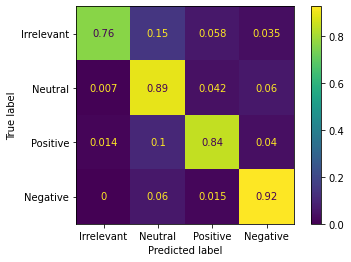

In [286]:
y_unique = list(set(y_test_labels))
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=y_unique, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_unique)
disp.plot()

## LSTM classification Supervised modeling techniques

Read about the [Bidirectional](https://keras.io/layers/wrappers/) wrapper in the Keras documentation. This architecture use two bidirectional RNN layer, before a dense layer.  The added value of a bidirectional RNN is described well in [this paper](http://www.cs.toronto.edu/~hinton/absps/DRNN_speech.pdf).

<img src="images/bidirectional_rnn_model.png" width="80%">

In [58]:
model = tf.keras.models.Sequential([
tf.keras.layers.Embedding(10000, 16, input_length=train_df.shape[1]),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50, return_sequences=True)),
tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(50)),
tf.keras.layers.Dense(4, activation='softmax')
])

loss_function = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(
     loss=loss_function,
     optimizer='adam',
     metrics=['accuracy']
)

In [59]:
h = model.fit(
    train_df, y_train,
    validation_data=(test_df, y_test),
    epochs=20,
    callbacks=[tf.keras.callbacks.EarlyStopping(monitor='accuracy', patience=5)]
)

Epoch 1/20
2234/2234 [==============================] - 59s 25ms/step - loss: 0.9564 - accuracy: 0.6053 - val_loss: 0.6182 - val_accuracy: 0.7800
Epoch 2/20
2234/2234 [==============================] - 55s 25ms/step - loss: 0.6256 - accuracy: 0.7644 - val_loss: 0.3830 - val_accuracy: 0.8710
Epoch 3/20
2234/2234 [==============================] - 57s 25ms/step - loss: 0.4773 - accuracy: 0.8249 - val_loss: 0.3224 - val_accuracy: 0.8790
Epoch 4/20
2234/2234 [==============================] - 56s 25ms/step - loss: 0.4052 - accuracy: 0.8483 - val_loss: 0.2877 - val_accuracy: 0.9070
Epoch 5/20
2234/2234 [==============================] - 56s 25ms/step - loss: 0.3586 - accuracy: 0.8660 - val_loss: 0.2692 - val_accuracy: 0.9000
Epoch 6/20
2234/2234 [==============================] - 56s 25ms/step - loss: 0.3216 - accuracy: 0.8791 - val_loss: 0.2797 - val_accuracy: 0.9150
Epoch 7/20
2234/2234 [==============================] - 56s 25ms/step - loss: 0.2920 - accuracy: 0.8900 - val_loss: 0.2631 -

In [290]:
#Generate predictions
y_pred = np.argmax(model.predict(test_df), axis=1)

#Assign labels to predictions and test data
y_pred_labels = ids_to_names(y_pred)
y_test_labels = ids_to_names(y_test)

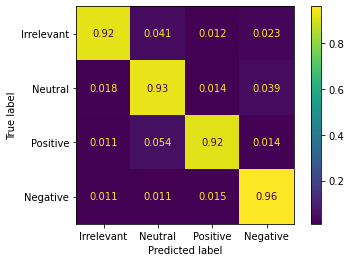

In [291]:
y_unique = list(set(y_test_labels))
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=y_unique, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_unique)
disp.plot()

It is evident from the above results that deep learning yields higher performance with an average of 93.25% compared to using Random-Forest classification model that yields an average of 85.25%. That is a 9.4% improvement.

# Save and load deep learning model

In [292]:
filename = '../models/finalized_model_proposed.h5'

In [293]:
model.save(filename)

In [294]:
del model  # deletes the existing model

In [295]:
# returns a compiled model
model = load_model(filename)

In [296]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, 62, 16)            160000    
                                                                 
 bidirectional_2 (Bidirectio  (None, 62, 100)          26800     
 nal)                                                            
                                                                 
 bidirectional_3 (Bidirectio  (None, 100)              60400     
 nal)                                                            
                                                                 
 dense_1 (Dense)             (None, 4)                 404       
                                                                 
Total params: 247,604
Trainable params: 247,604
Non-trainable params: 0
_________________________________________________________________


In [297]:
#Generate predictions
y_pred = np.argmax(model.predict(test_df), axis=1)

#Assign labels to predictions and test data
y_pred_labels = ids_to_names(y_pred)
y_test_labels = ids_to_names(y_test)

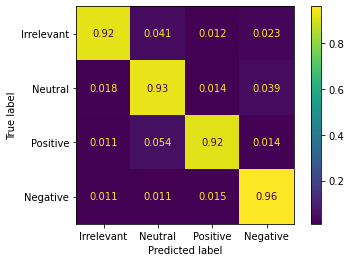

In [298]:
y_unique = list(set(y_test_labels))
cm = confusion_matrix(y_test_labels, y_pred_labels, labels=y_unique, normalize='true')

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=y_unique)
disp.plot()

# Unsupervised techniques

TextBlob’s output for a polarity task is a float within the range [-1.0, 1.0] where -1.0 is a negative polarity and 1.0 is positive. This score can also be equal to 0, which stands for a neutral evaluation of a statement as it doesn’t contain any words from the training set.

In [5]:
# Due to special charas should be encoded as latin 1

train_tweet_df = pd.read_csv("../data/processed/cleaned_tweet_train.csv")
train_tweet_df.drop(['Unnamed: 0'], axis=1, inplace=True)

test_tweet_df = pd.read_csv("../data/processed/cleaned_tweet_test.csv")
test_tweet_df.drop(['Unnamed: 0'], axis=1, inplace=True)

We only use the tweets to build an unsupervised model. This can help us to understand the grouping of the tweets and posibley to lable them. For simplicity, we start by removing any missing value.  

In [6]:
train_tweet_df["Tweet_Content"] = train_tweet_df["Tweet_Content"].astype(str)
test_tweet_df["Tweet_Content"] = test_tweet_df["Tweet_Content"].astype(str)

In [7]:
train_tweet_df = train_tweet_df.dropna()
test_tweet_df = test_tweet_df.dropna()

In [8]:
train_tweet_df.head()

,Entity,Sentiment,Tweet_Content,char_count,word_count,sent_count,capital_char_count,capital_word_count,quoted_word_count,stopword_count,...,[ count,\ count,] count,^ count,_ count,` count,{ count,| count,} count,~ count
0,4,3,get borderland murder,53,11,1,0,0,0,6,...,0,0,0,0,0,0,0,0,0,0
1,4,3,border kill,51,12,1,2,2,0,7,...,0,0,0,0,0,0,0,0,0,0
2,4,3,get borderland kill,50,10,1,0,0,0,6,...,0,0,0,0,0,0,0,0,0,0
3,4,3,borderland murder,51,10,1,0,0,0,6,...,0,0,0,0,0,0,0,0,0,0
4,4,3,get borderland murder,57,12,1,0,0,0,7,...,0,0,0,0,0,0,0,0,0,0


In [9]:
train_tweet_df['Tweet_Content']

0                                    get borderland murder
1                                              border kill
2                                      get borderland kill
3                                        borderland murder
4                                    get borderland murder
                               ...                        
71651    realize window partite mac like year behind in...
71652    realize mac window partite year behind india d...
71653    realize window partite mac year behind india d...
71654    realize window partite mac like year behind in...
71655    like window partite mac like year behind drive...
Name: Tweet_Content, Length: 71484, dtype: object

The below function returns the polarity (score) from the text feature. 

In [10]:
def sentiment(text):
    senti =TextBlob(text)
    return senti.sentiment

test_tweet_df['polarity']=test_tweet_df['Tweet_Content'].apply(sentiment).apply(lambda b: b[0])

test_tweet_df.head()

,Entity,Sentiment,Tweet_Content,char_count,word_count,sent_count,capital_char_count,capital_word_count,quoted_word_count,stopword_count,...,\ count,] count,^ count,_ count,` count,{ count,| count,} count,~ count,polarity
0,11,1,mention facebook struggle motive go run day tr...,242,47,1,6,2,0,26,...,0,0,0,0,0,0,0,0,0,0.0125
1,0,0,bc news amazon boss jeff be reject claim compa...,109,16,1,7,1,0,1,...,0,0,0,0,0,0,0,0,0,0.0000
2,19,2,microsoft pay word function poor samsungus chr...,91,17,2,11,2,0,7,...,0,0,0,0,0,0,0,0,0,-0.4000
3,5,2,so watchman full closet hack truly a,71,13,1,4,1,0,5,...,0,0,0,0,0,0,0,0,0,0.3500
4,13,0,preside slap american really commit law act ac...,170,25,2,6,0,0,11,...,0,0,0,0,0,0,0,0,0,0.3000


For simplicity, we remove the Irrelevant sentiment class. The polarity is used to classify one of these classes: neutral, Negative, or positive.

In [11]:
test_tweet_df = test_tweet_df[test_tweet_df.Sentiment.isin([0, 2, 3])]

"Neutral":0, "Irrelevant":1, "Negative":2, "Positive": 3

In [12]:
def categories(pol):
    if pol == 0:
        return 0
    elif pol < 0:
        return 2
    else:
        return 3
    
    
test_tweet_df['pd_sentiment']=test_tweet_df['polarity'].apply(categories)
test_tweet_df.head()

,Entity,Sentiment,Tweet_Content,char_count,word_count,sent_count,capital_char_count,capital_word_count,quoted_word_count,stopword_count,...,] count,^ count,_ count,` count,{ count,| count,} count,~ count,polarity,pd_sentiment
1,0,0,bc news amazon boss jeff be reject claim compa...,109,16,1,7,1,0,1,...,0,0,0,0,0,0,0,0,0.00000,0
2,19,2,microsoft pay word function poor samsungus chr...,91,17,2,11,2,0,7,...,0,0,0,0,0,0,0,0,-0.40000,2
3,5,2,so watchman full closet hack truly a,71,13,1,4,1,0,5,...,0,0,0,0,0,0,0,0,0.35000,3
4,13,0,preside slap american really commit law act ac...,170,25,2,6,0,0,11,...,0,0,0,0,0,0,0,0,0.30000,3
5,10,2,hi help mallein mann cellar past year little s...,268,52,1,10,1,0,27,...,0,0,0,0,0,0,0,0,-0.21875,2


We can see that the performance from Unsupervised is substantially lower compared to the supervised algorithms. That is normally the case. However, using an unsupervised algorithm gives us a starting point and can speed up the labeling process compared to manually labeling the tweets. Perhaps combining a recommender engine with an unsupervised algorithm to automate the labeling process, where the user can seamlessly correct the prediction from the recommendation. That eventually aiding in labeling the dataset inorder to apply more advanced supervised algorithms.   

In [13]:
accuracy_score(test_tweet_df.pd_sentiment, test_tweet_df.Sentiment)

0.42632850241545894

Plot the sentiment with WordCloud

In [245]:
pos_riv=test_tweet_df[test_tweet_df['pd_sentiment']== 3]
pos_riv=pos_riv[pos_riv['polarity']>0]
print(pos_riv)
print(len(pos_riv))

     Entity  Sentiment                                      Tweet_Content  \
3         5          2               so watchman full closet hack truly a   
4        13          0  preside slap american really commit law act ac...   
6        18          3  thank eamaddennfl new austin cooper rang brown...   
7        27          3  rocket league thief rainbow six siege🤔 love pl...   
10        9          3  profession data scene fuck explode complete we...   
..      ...        ...                                                ...   
988      17          0  ♥️ suikoden d️⃣ flex kind miracle world person...   
989      16          3  thank match fund home depot re payment dddddd ...   
990      27          3  tom chance rainbow six sing great play neat we...   
994      23          3     good son much see new pad go right much import   
998      19          3          bought fraction microsoft today small win   

     char_count  word_count  sent_count  capital_char_count  \
3           

In [246]:
all_positive=" ".join(pos_riv['Tweet_Content'])

In [247]:
st_words=set(stopwords.words('english'))
st_words.update(['cnnpolitics','CNN','one','also','still','however','become'])

In [248]:
po_wcloud=WordCloud(width = 1000, height = 1000, 
                    background_color ='white', 
                    stopwords = st_words, 
                    min_font_size = 10).generate(all_positive)

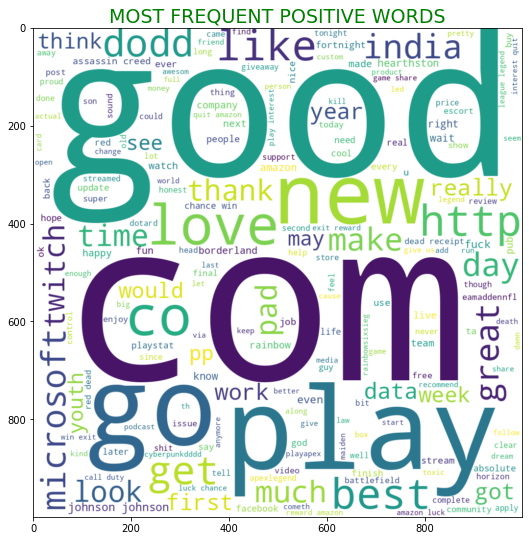

In [249]:
plt.figure(figsize=(12,9))
plt.title("MOST FREQUENT POSITIVE WORDS",fontdict={'color':"green",'fontsize':19})
plt.imshow(po_wcloud,interpolation='bilinear')
plt.show()

Sorry for below negative words!!!

In [250]:
# negative
neg_riv=test_tweet_df[test_tweet_df['pd_sentiment'] == 2]
neg_riv=neg_riv[neg_riv['polarity']<0]
print(neg_riv)
print(neg_riv)

     Entity  Sentiment                                      Tweet_Content  \
2        19          2  microsoft pay word function poor samsungus chr...   
5        10          2  hi help mallein mann cellar past year little s...   
14       20          2           bad ok suck second left team intent foul   
17        9          2                                          fuck life   
18       25          3  happy birthday red dead receipt shit change li...   
..      ...        ...                                                ...   
977      13          0  odd good suggest dead terrors attack commit us...   
983       9          2                                               fuck   
985      25          0  th__man play red dead redemption oh shit bear ...   
991       6          0  late night stream boy watch watson run struggl...   
997       4          3  today suck time drink wine play borderland sun...   

     char_count  word_count  sent_count  capital_char_count  \
2           

In [251]:
all_negative=" ".join(neg_riv['Tweet_Content'])

In [252]:
neg_wcloud=WordCloud(width = 1000, height = 1000, 
                background_color ='white', 
                stopwords = st_words, 
                min_font_size = 10).generate(all_negative)

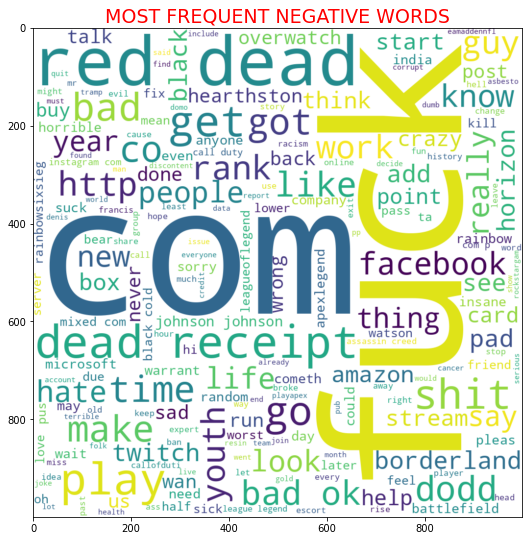

In [253]:
plt.figure(figsize=(12,9))
plt.title("MOST FREQUENT NEGATIVE WORDS",fontdict={'color':'red','fontsize':19})
plt.imshow(neg_wcloud,interpolation='bilinear')
plt.show()

In [254]:
# negative
neg_riv=test_tweet_df[test_tweet_df['pd_sentiment'] == 0]
neg_riv=neg_riv[neg_riv['polarity'] == 0]
print(neg_riv)
print(neg_riv)

     Entity  Sentiment                                      Tweet_Content  \
1         0          0  bc news amazon boss jeff be reject claim compa...   
8         2          3  ass still kneedeep assassin creed odyssey way ...   
9         6          2  fix jesus pleas fix world go playstat askplays...   
11        2          3  pitch assassin tccgif assassinscreedblackflag ...   
12       28          2  fredtjoseph hey fred coast cut call horizon st...   
..      ...        ...                                                ...   
979      27          2  rainbow ban ink/crony player console is/box th...   
981      29          3                           warcraftdev would inured   
992       9          3                                        guess broke   
993       0          2  pleas explain possible let company overcharg s...   
999      31          0  johnson johnson stop sell talk baby powder can...   

     char_count  word_count  sent_count  capital_char_count  \
1           

In [255]:
all_neutral =" ".join(neg_riv['Tweet_Content'])

In [256]:
neg_wcloud=WordCloud(width = 1000, height = 1000, 
                background_color ='white', 
                stopwords = st_words, 
                min_font_size = 10).generate(all_neutral)

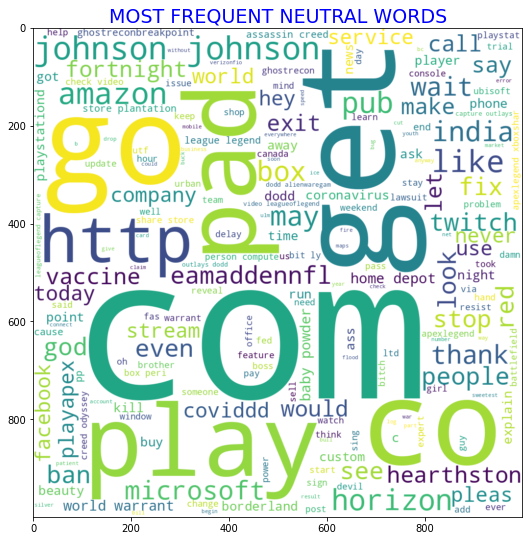

In [257]:
plt.figure(figsize=(12,9))
plt.title("MOST FREQUENT NEUTRAL WORDS",fontdict={'color':'blue','fontsize':19})
plt.imshow(neg_wcloud,interpolation='bilinear')
plt.show()

# Summary

Now that we have a saved model. you can deploy it into your infrastructure. This model can help you to:

* Improve customer service
Enable the business to respond to issues promptly before the customer churn to competitor. 
* Boost product and services
This is where issues and bugs are reported by customers as a priceless feedback loop. Therefore, performing the sentiment analysis on the customer reviews can help businesses to identify what is lacking, which should lead to improvement.
* Better marketing campaigns
Companies can get powerful insights from industry trends by analyzing sentiment towards new features or products on social media to boost marketing strategy.

If you find this information helpful and would like to learn more about ML models, feel free to [reach out to the phData ML team](https://www.phdata.io/contact-us/). We’re here to help!